# Tutorial for Modeling SIMP0136 Variability

by Michael K. Plummer

This is a companion tutorial for "Atmospheric Waves Driving Variability and Cloud Formation on a Planetary-Mass Object" by Plummer et al. (Submitted). Here we will walkthrough our code, figures, and computations.

We start by importing our dependencies.

In [1]:
import matplotlib.gridspec as gridspec
from SecretColors import Palette
from scipy.io import readsav
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import dynesty
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import Imber30 as Imber
import pandas as pd

Add fundamental properites for our astronomical taget, SIMP0136

In [2]:
'Setup Target'
vsini = 52.8  # [km/s], Vos+ (2017)
inclination = 80.0 # [deg], Vos+ (2017) 
period = 2.414 # [hrs], Yang+ (2016)
SIMP0136 = Imber.Target(vsini, inclination, period)

target = SIMP0136
period_hours = target.period

Import data (gathered at the Canada-France-Hawaii Telescope). We delete out bad data points and convert dates to hours and rotations.

In [3]:
''''Import CSV File'''
''''''''''''''''''''

'Import Data'
data = pd.read_csv('/Users/plummer.323/Documents/PhDResearch/SIMP0136_Variability/SIMP0136+0933_fluxes_7Feb.csv')
'Import Filter Bands'
band = np.array(data['FILTER'])
'Define indices for each filter band'
indices_J = np.where(band == 'J')[0]
indices_H = np.where(band == 'H')[0]
indices_K = np.where(band == 'K')[0]
indices_Y = np.where(band == 'Y')[0]
indices_J_high_cadence = indices_J[:111]
indices_J_low_cadence = indices_J[111:]
indices_low_all = np.arange(111,164,1)

'Flux for each filter band/cadence'
flux_J = np.array( data['flux_corr'][indices_J])
flux_J_high_cadence =np.array( data['flux_corr'][indices_J_high_cadence])
flux_J_low_cadence = np.array(data['flux_corr'][indices_J_low_cadence])
flux_H = np.array(data['flux_corr'][indices_H])
flux_K = np.array(data['flux_corr'][indices_K])
flux_Y = np.array(data['flux_corr'][indices_Y])
flux_low_all = np.array(data['flux_corr'][indices_low_all])

'Error for each filter band/cadence'
error_J = np.array(data['sigma_flux_corr'][indices_J])
error_J_high_cadence = np.array(data['sigma_flux_corr'][indices_J_high_cadence])
error_J_high_cadence = np.array(data['sigma_flux_corr'][indices_J_high_cadence])
error_J_low_cadence = np.array(data['sigma_flux_corr'][indices_J_low_cadence])
error_H = np.array(data['sigma_flux_corr'][indices_H])
error_K = np.array(data['sigma_flux_corr'][indices_K])
error_Y = np.array(data['sigma_flux_corr'][indices_Y])
error_low_all = np.array(data['sigma_flux_corr'][indices_low_all])
''
'Time Formatting'
mjdate = np.array(data['MJDATE'])
mjdate_J = mjdate[indices_J]
mjdate_J_high_cadence = mjdate[indices_J_high_cadence]
mjdate_J_low_cadence = mjdate[indices_J_low_cadence]
mjdate_H = mjdate[indices_H]
mjdate_K = mjdate[indices_K]
mjdate_Y = mjdate[indices_Y]
mjdate_low_all = mjdate[indices_low_all]

day2_J = mjdate_J_low_cadence-mjdate_J_high_cadence[0]
hours_day2_J = day2_J*24

days_J = mjdate_J-mjdate_J[0]
days_J_high_cadence = mjdate_J_high_cadence-mjdate_J_high_cadence[0]
days_J_low_cadence = mjdate_J_low_cadence-mjdate_K[0]
days_H = mjdate_H-mjdate_K[0]
days_K = mjdate_K-mjdate_K[0]
days_Y = mjdate_Y-mjdate_K[0]
days_low_all = mjdate_low_all-mjdate_K[0]

earth_day = 23.9333333
hours_J = days_J*earth_day
hours_J_high_cadence = days_J_high_cadence*earth_day
hours_J_low_cadence = days_J_low_cadence*earth_day
hours_H = days_H*earth_day
hours_K = days_K*earth_day
hours_Y = days_Y*earth_day
hours_low_all = days_low_all*earth_day

rotations_J = hours_J/period_hours
rotations_J_high_cadence = hours_J_high_cadence/period_hours
rotations_J_low_cadence = hours_J_low_cadence/period_hours
rotations_H = hours_H/period_hours
rotations_K = hours_K/period_hours
rotations_Y = hours_Y/period_hours
rotations_low_all = hours_low_all/period_hours

'Raw Light Curves Inputs'
flux_raw_Jhi_target =np.array( data['FLUX_0'][indices_J_high_cadence])
flux_raw_Jhi_ref1 =np.array( data['FLUX_1'][indices_J_high_cadence])
flux_raw_Jhi_ref2 =np.array( data['FLUX_2'][indices_J_high_cadence])
flux_raw_Jhi_ref3 =np.array( data['FLUX_3'][indices_J_high_cadence])
flux_raw_Jhi_ref4 =np.array( data['FLUX_4'][indices_J_high_cadence])
flux_raw_Jhi_ref5 =np.array( data['FLUX_5'][indices_J_high_cadence])
flux_raw_Jlow_target =np.array( data['FLUX_0'][indices_J_low_cadence])
flux_raw_Jlow_ref1 =np.array( data['FLUX_1'][indices_J_low_cadence])
flux_raw_Jlow_ref2 =np.array( data['FLUX_2'][indices_J_low_cadence])
flux_raw_Jlow_ref3 =np.array( data['FLUX_3'][indices_J_low_cadence])
flux_raw_Jlow_ref4 =np.array( data['FLUX_4'][indices_J_low_cadence])
flux_raw_Jlow_ref5 =np.array( data['FLUX_5'][indices_J_low_cadence])
flux_raw_H_target =np.array( data['FLUX_0'][indices_H])
flux_raw_H_ref1 =np.array( data['FLUX_1'][indices_H])
flux_raw_H_ref2 =np.array( data['FLUX_2'][indices_H])
flux_raw_H_ref3 =np.array( data['FLUX_3'][indices_H])
flux_raw_H_ref4 =np.array( data['FLUX_4'][indices_H])
flux_raw_H_ref5 =np.array( data['FLUX_5'][indices_H])
flux_raw_K_target =np.array( data['FLUX_0'][indices_K])
flux_raw_K_ref1 =np.array( data['FLUX_1'][indices_K])
flux_raw_K_ref2 =np.array( data['FLUX_2'][indices_K])
flux_raw_K_ref3 =np.array( data['FLUX_3'][indices_K])
flux_raw_K_ref4 =np.array( data['FLUX_4'][indices_K])
flux_raw_K_ref5 =np.array( data['FLUX_5'][indices_K])
flux_raw_Y_target =np.array( data['FLUX_0'][indices_Y])
flux_raw_Y_ref1 =np.array( data['FLUX_1'][indices_Y])
flux_raw_Y_ref2 =np.array( data['FLUX_2'][indices_Y])
flux_raw_Y_ref3 =np.array( data['FLUX_3'][indices_Y])
flux_raw_Y_ref4 =np.array( data['FLUX_4'][indices_Y])
flux_raw_Y_ref5 =np.array( data['FLUX_5'][indices_Y])

'Delete Bad J high cadence points'
bad_index = np.where(flux_raw_Jhi_target-min(flux_raw_Jhi_target)<0.1)[0][0]
bad_index_array = np.array([bad_index,bad_index+2])

flux_J_high_cadence = np.delete(flux_J_high_cadence,bad_index_array)
error_J_high_cadence = np.delete(error_J_high_cadence,bad_index_array)
mjdate_J_high_cadence = np.delete(mjdate_J_high_cadence,bad_index_array)
days_J_high_cadence = np.delete(days_J_high_cadence,bad_index_array)
hours_J_high_cadence = np.delete(hours_J_high_cadence,bad_index_array)
rotations_J_high_cadence = np.delete(rotations_J_high_cadence,bad_index_array)
 
flux_raw_Jhi_target = np.delete(flux_raw_Jhi_target,bad_index_array)
flux_raw_Jhi_ref1 = np.delete(flux_raw_Jhi_ref1,bad_index_array)
flux_raw_Jhi_ref2 = np.delete(flux_raw_Jhi_ref2,bad_index_array)
flux_raw_Jhi_ref3 = np.delete(flux_raw_Jhi_ref3,bad_index_array)
flux_raw_Jhi_ref4 = np.delete(flux_raw_Jhi_ref4,bad_index_array)
flux_raw_Jhi_ref5 =np.delete(flux_raw_Jhi_ref5,bad_index_array)

flux_J = np.delete(flux_J,bad_index_array)
error_J = np.delete(error_J,bad_index_array)
mjdate_J = np.delete(mjdate_J,bad_index_array)
days_J = np.delete(days_J,bad_index_array)
hours_J = np.delete(hours_J,bad_index_array)
rotations_J = np.delete(rotations_J,bad_index_array)

We peform differential photometry for both observation nights (Figures 1 & 2).

In [4]:
'Mean Normalized Light Curves - J high cadence'
flux_raw_Jhi_target_norm = flux_raw_Jhi_target/np.mean(flux_raw_Jhi_target)
flux_raw_Jhi_ref1_norm = flux_raw_Jhi_ref1/np.mean(flux_raw_Jhi_ref1)
flux_raw_Jhi_ref2_norm = flux_raw_Jhi_ref2/np.mean(flux_raw_Jhi_ref2)
flux_raw_Jhi_ref3_norm = flux_raw_Jhi_ref3/np.mean(flux_raw_Jhi_ref3)
flux_raw_Jhi_ref4_norm = flux_raw_Jhi_ref4/np.mean(flux_raw_Jhi_ref4)
flux_raw_Jhi_ref5_norm = flux_raw_Jhi_ref5/np.mean(flux_raw_Jhi_ref5)
mean_norm_ref = np.mean(np.array([flux_raw_Jhi_ref1_norm,flux_raw_Jhi_ref2_norm,flux_raw_Jhi_ref3_norm,flux_raw_Jhi_ref4_norm,flux_raw_Jhi_ref5_norm]),axis = 0)
mean_norm_ref1 = np.mean(np.array([flux_raw_Jhi_ref2_norm,flux_raw_Jhi_ref3_norm,flux_raw_Jhi_ref4_norm,flux_raw_Jhi_ref5_norm]),axis = 0)
mean_norm_ref2 = np.mean(np.array([flux_raw_Jhi_ref1_norm,flux_raw_Jhi_ref3_norm,flux_raw_Jhi_ref4_norm,flux_raw_Jhi_ref5_norm]),axis = 0)
mean_norm_ref3 = np.mean(np.array([flux_raw_Jhi_ref1_norm,flux_raw_Jhi_ref2_norm,flux_raw_Jhi_ref4_norm,flux_raw_Jhi_ref5_norm]),axis = 0)
mean_norm_ref4 = np.mean(np.array([flux_raw_Jhi_ref1_norm,flux_raw_Jhi_ref2_norm,flux_raw_Jhi_ref3_norm,flux_raw_Jhi_ref5_norm]),axis = 0)
mean_norm_ref5 = np.mean(np.array([flux_raw_Jhi_ref1_norm,flux_raw_Jhi_ref2_norm,flux_raw_Jhi_ref3_norm,flux_raw_Jhi_ref4_norm]),axis = 0)
flux_ref = flux_raw_Jhi_target_norm/mean_norm_ref
flux_ref1 = flux_raw_Jhi_ref1_norm/mean_norm_ref1
flux_ref2 = flux_raw_Jhi_ref2_norm/mean_norm_ref2
flux_ref3 = flux_raw_Jhi_ref3_norm/mean_norm_ref3
flux_ref4 = flux_raw_Jhi_ref4_norm/mean_norm_ref4
flux_ref5 = flux_raw_Jhi_ref5_norm/mean_norm_ref5

'Mean Normalized Light Curves - Low Cadence'
'J low'
flux_raw_Jlow_target_norm = flux_raw_Jlow_target/np.mean(flux_raw_Jlow_target)
flux_raw_Jlow_ref1_norm = flux_raw_Jlow_ref1/np.mean(flux_raw_Jlow_ref1)
flux_raw_Jlow_ref2_norm = flux_raw_Jlow_ref2/np.mean(flux_raw_Jlow_ref2)
flux_raw_Jlow_ref3_norm = flux_raw_Jlow_ref3/np.mean(flux_raw_Jlow_ref3)
flux_raw_Jlow_ref4_norm = flux_raw_Jlow_ref4/np.mean(flux_raw_Jlow_ref4)
flux_raw_Jlow_ref5_norm = flux_raw_Jlow_ref5/np.mean(flux_raw_Jlow_ref5)
mean_norm_ref = np.mean(np.array([flux_raw_Jlow_ref1_norm,flux_raw_Jlow_ref2_norm,flux_raw_Jlow_ref3_norm,flux_raw_Jlow_ref4_norm,flux_raw_Jlow_ref5_norm]),axis = 0)
mean_norm_ref1 = np.mean(np.array([flux_raw_Jlow_ref2_norm,flux_raw_Jlow_ref3_norm,flux_raw_Jlow_ref4_norm,flux_raw_Jlow_ref5_norm]),axis = 0)
mean_norm_ref2 = np.mean(np.array([flux_raw_Jlow_ref1_norm,flux_raw_Jlow_ref3_norm,flux_raw_Jlow_ref4_norm,flux_raw_Jlow_ref5_norm]),axis = 0)
mean_norm_ref3 = np.mean(np.array([flux_raw_Jlow_ref1_norm,flux_raw_Jlow_ref2_norm,flux_raw_Jlow_ref4_norm,flux_raw_Jlow_ref5_norm]),axis = 0)
mean_norm_ref4 = np.mean(np.array([flux_raw_Jlow_ref1_norm,flux_raw_Jlow_ref2_norm,flux_raw_Jlow_ref3_norm,flux_raw_Jlow_ref5_norm]),axis = 0)
mean_norm_ref5 = np.mean(np.array([flux_raw_Jlow_ref1_norm,flux_raw_Jlow_ref2_norm,flux_raw_Jlow_ref3_norm,flux_raw_Jlow_ref4_norm]),axis = 0)
flux_Jlow_ref = flux_raw_Jlow_target_norm/mean_norm_ref
flux_Jlow_ref1 = flux_raw_Jlow_ref1_norm/mean_norm_ref1
flux_Jlow_ref2 = flux_raw_Jlow_ref2_norm/mean_norm_ref2
flux_Jlow_ref3 = flux_raw_Jlow_ref3_norm/mean_norm_ref3
flux_Jlow_ref4 = flux_raw_Jlow_ref4_norm/mean_norm_ref4
flux_Jlow_ref5 = flux_raw_Jlow_ref5_norm/mean_norm_ref5
'H'
flux_raw_H_target_norm = flux_raw_H_target/np.mean(flux_raw_H_target)
flux_raw_H_ref1_norm = flux_raw_H_ref1/np.mean(flux_raw_H_ref1)
flux_raw_H_ref2_norm = flux_raw_H_ref2/np.mean(flux_raw_H_ref2)
flux_raw_H_ref3_norm = flux_raw_H_ref3/np.mean(flux_raw_H_ref3)
flux_raw_H_ref4_norm = flux_raw_H_ref4/np.mean(flux_raw_H_ref4)
flux_raw_H_ref5_norm = flux_raw_H_ref5/np.mean(flux_raw_H_ref5)
mean_norm_ref = np.mean(np.array([flux_raw_H_ref1_norm,flux_raw_H_ref2_norm,flux_raw_H_ref3_norm,flux_raw_H_ref4_norm,flux_raw_H_ref5_norm]),axis = 0)
mean_norm_ref1 = np.mean(np.array([flux_raw_H_ref2_norm,flux_raw_H_ref3_norm,flux_raw_H_ref4_norm,flux_raw_H_ref5_norm]),axis = 0)
mean_norm_ref2 = np.mean(np.array([flux_raw_H_ref1_norm,flux_raw_H_ref3_norm,flux_raw_H_ref4_norm,flux_raw_H_ref5_norm]),axis = 0)
mean_norm_ref3 = np.mean(np.array([flux_raw_H_ref1_norm,flux_raw_H_ref2_norm,flux_raw_H_ref4_norm,flux_raw_H_ref5_norm]),axis = 0)
mean_norm_ref4 = np.mean(np.array([flux_raw_H_ref1_norm,flux_raw_H_ref2_norm,flux_raw_H_ref3_norm,flux_raw_H_ref5_norm]),axis = 0)
mean_norm_ref5 = np.mean(np.array([flux_raw_H_ref1_norm,flux_raw_H_ref2_norm,flux_raw_H_ref3_norm,flux_raw_H_ref4_norm]),axis = 0)
flux_H_ref = flux_raw_H_target_norm/mean_norm_ref
flux_H_ref1 = flux_raw_H_ref1_norm/mean_norm_ref1
flux_H_ref2 = flux_raw_H_ref2_norm/mean_norm_ref2
flux_H_ref3 = flux_raw_H_ref3_norm/mean_norm_ref3
flux_H_ref4 = flux_raw_H_ref4_norm/mean_norm_ref4
flux_H_ref5 = flux_raw_H_ref5_norm/mean_norm_ref5
'K'
flux_raw_K_target_norm = flux_raw_K_target/np.mean(flux_raw_K_target)
flux_raw_K_ref1_norm = flux_raw_K_ref1/np.mean(flux_raw_K_ref1)
flux_raw_K_ref2_norm = flux_raw_K_ref2/np.mean(flux_raw_K_ref2)
flux_raw_K_ref3_norm = flux_raw_K_ref3/np.mean(flux_raw_K_ref3)
flux_raw_K_ref4_norm = flux_raw_K_ref4/np.mean(flux_raw_K_ref4)
flux_raw_K_ref5_norm = flux_raw_K_ref5/np.mean(flux_raw_K_ref5)
mean_norm_ref = np.mean(np.array([flux_raw_K_ref1_norm,flux_raw_K_ref2_norm,flux_raw_K_ref3_norm,flux_raw_K_ref4_norm,flux_raw_K_ref5_norm]),axis = 0)
mean_norm_ref1 = np.mean(np.array([flux_raw_K_ref2_norm,flux_raw_K_ref3_norm,flux_raw_K_ref4_norm,flux_raw_K_ref5_norm]),axis = 0)
mean_norm_ref2 = np.mean(np.array([flux_raw_K_ref1_norm,flux_raw_K_ref3_norm,flux_raw_K_ref4_norm,flux_raw_K_ref5_norm]),axis = 0)
mean_norm_ref3 = np.mean(np.array([flux_raw_K_ref1_norm,flux_raw_K_ref2_norm,flux_raw_K_ref4_norm,flux_raw_K_ref5_norm]),axis = 0)
mean_norm_ref4 = np.mean(np.array([flux_raw_K_ref1_norm,flux_raw_K_ref2_norm,flux_raw_K_ref3_norm,flux_raw_K_ref5_norm]),axis = 0)
mean_norm_ref5 = np.mean(np.array([flux_raw_K_ref1_norm,flux_raw_K_ref2_norm,flux_raw_K_ref3_norm,flux_raw_K_ref4_norm]),axis = 0)
flux_K_ref = flux_raw_K_target_norm/mean_norm_ref
flux_K_ref1 = flux_raw_K_ref1_norm/mean_norm_ref1
flux_K_ref2 = flux_raw_K_ref2_norm/mean_norm_ref2
flux_K_ref3 = flux_raw_K_ref3_norm/mean_norm_ref3
flux_K_ref4 = flux_raw_K_ref4_norm/mean_norm_ref4
flux_K_ref5 = flux_raw_K_ref5_norm/mean_norm_ref5

'Y'
flux_raw_Y_target_norm = flux_raw_Y_target/np.mean(flux_raw_Y_target)
flux_raw_Y_ref1_norm = flux_raw_Y_ref1/np.mean(flux_raw_Y_ref1)
flux_raw_Y_ref2_norm = flux_raw_Y_ref2/np.mean(flux_raw_Y_ref2)
flux_raw_Y_ref3_norm = flux_raw_Y_ref3/np.mean(flux_raw_Y_ref3)
flux_raw_Y_ref4_norm = flux_raw_Y_ref4/np.mean(flux_raw_Y_ref4)
flux_raw_Y_ref5_norm = flux_raw_Y_ref5/np.mean(flux_raw_Y_ref5)
mean_norm_ref = np.mean(np.array([flux_raw_Y_ref1_norm,flux_raw_Y_ref2_norm,flux_raw_Y_ref3_norm,flux_raw_Y_ref4_norm,flux_raw_Y_ref5_norm]),axis = 0)
mean_norm_ref1 = np.mean(np.array([flux_raw_Y_ref2_norm,flux_raw_Y_ref3_norm,flux_raw_Y_ref4_norm,flux_raw_Y_ref5_norm]),axis = 0)
mean_norm_ref2 = np.mean(np.array([flux_raw_Y_ref1_norm,flux_raw_Y_ref3_norm,flux_raw_Y_ref4_norm,flux_raw_Y_ref5_norm]),axis = 0)
mean_norm_ref3 = np.mean(np.array([flux_raw_Y_ref1_norm,flux_raw_Y_ref2_norm,flux_raw_Y_ref4_norm,flux_raw_Y_ref5_norm]),axis = 0)
mean_norm_ref4 = np.mean(np.array([flux_raw_Y_ref1_norm,flux_raw_Y_ref2_norm,flux_raw_Y_ref3_norm,flux_raw_Y_ref5_norm]),axis = 0)
mean_norm_ref5 = np.mean(np.array([flux_raw_Y_ref1_norm,flux_raw_Y_ref2_norm,flux_raw_Y_ref3_norm,flux_raw_Y_ref4_norm]),axis = 0)
flux_Y_ref = flux_raw_Y_target_norm/mean_norm_ref
flux_Y_ref1 = flux_raw_Y_ref1_norm/mean_norm_ref1
flux_Y_ref2 = flux_raw_Y_ref2_norm/mean_norm_ref2
flux_Y_ref3 = flux_raw_Y_ref3_norm/mean_norm_ref3
flux_Y_ref4 = flux_raw_Y_ref4_norm/mean_norm_ref4
flux_Y_ref5 = flux_raw_Y_ref5_norm/mean_norm_ref5

We plot the raw and corrected photometry for each night (Figures 1 and 2).

Text(0.5, 0, 'Hours')

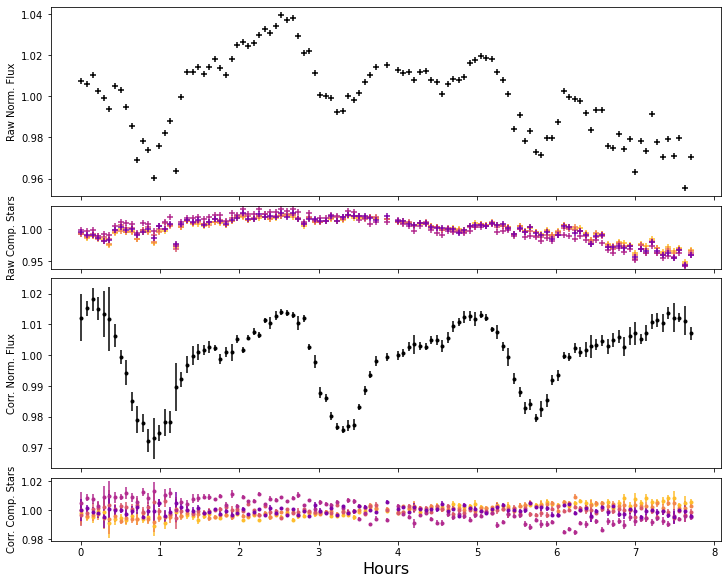

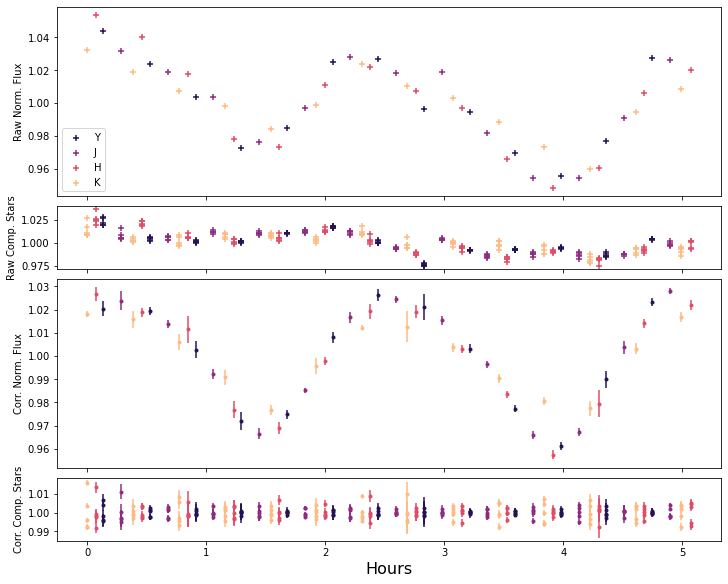

In [21]:
'''START FIGURES'''
from matplotlib import gridspec
import matplotlib.pylab as pl

'Setup Colors'
p = Palette("ibm")  # 'ibm' 'brewer' 'material' 'clarity
n = 100
colour = pl.cm.plasma(np.linspace(0,1,n))
color4,color3,color2,color1 = 80,60,40,20
color11,color12,color13,color14,color15 = 85,70,55,40,25

'Low Cadence Color'
lo_color = pl.cm.magma(np.linspace(0,1,n))
color_Y = lo_color[15]
color_J = lo_color[40]
color_H = lo_color[60]
color_K = lo_color[85]

'Fig. 00 -- Raw Data - J hi'
fig00 = plt.figure(constrained_layout=True,figsize=(10,8))
spec00 = gridspec.GridSpec(ncols=1, nrows=4, height_ratios = [3,1,3,1],figure=fig00)
ax04 = fig00.add_subplot(spec00[3])
ax01 = fig00.add_subplot(spec00[0],sharex=ax04)
ax02 = fig00.add_subplot(spec00[1],sharex=ax04)
ax03 = fig00.add_subplot(spec00[2],sharex=ax04)
plt.setp(ax01.get_xticklabels(), visible=False)
plt.setp(ax02.get_xticklabels(), visible=False)
plt.setp(ax03.get_xticklabels(), visible=False)
ax01.scatter(hours_J_high_cadence,flux_raw_Jhi_target/np.mean(flux_raw_Jhi_target),marker = '+',color = p.black())
ax02.scatter(hours_J_high_cadence,flux_raw_Jhi_ref1/np.mean(flux_raw_Jhi_ref1),marker = '+',color = colour[color11])
ax02.scatter(hours_J_high_cadence,flux_raw_Jhi_ref2/np.mean(flux_raw_Jhi_ref2),marker = '+',color = colour[color12])
ax02.scatter(hours_J_high_cadence,flux_raw_Jhi_ref3/np.mean(flux_raw_Jhi_ref3),marker = '+',color = colour[color13])
ax02.scatter(hours_J_high_cadence,flux_raw_Jhi_ref4/np.mean(flux_raw_Jhi_ref4),marker = '+',color = colour[color14])
ax02.scatter(hours_J_high_cadence,flux_raw_Jhi_ref5/np.mean(flux_raw_Jhi_ref5),marker = '+',color = colour[color15])
ax03.errorbar(hours_J_high_cadence,flux_ref,yerr = error_J_high_cadence,color = p.black(),ls = 'none',marker = '.')
ax04.errorbar(hours_J_high_cadence,flux_ref1,yerr = error_J_high_cadence,color = colour[color11],ls = 'none',marker = '.')
ax04.errorbar(hours_J_high_cadence,flux_ref2,yerr = error_J_high_cadence,color = colour[color12],ls = 'none',marker = '.')
ax04.errorbar(hours_J_high_cadence,flux_ref3,yerr = error_J_high_cadence,color = colour[color13],ls = 'none',marker = '.')
ax04.errorbar(hours_J_high_cadence,flux_ref4,yerr = error_J_high_cadence,color = colour[color14],ls = 'none',marker = '.')
ax04.errorbar(hours_J_high_cadence,flux_ref5,yerr = error_J_high_cadence,color = colour[color15],ls = 'none',marker = '.')

ax04.set_xlabel('Hours',fontsize = 16)
ax01.set_ylabel('Raw Norm. Flux')
ax02.set_ylabel('Raw Comp. Stars')
ax03.set_ylabel('Corr. Norm. Flux')
ax04.set_ylabel('Corr. Comp. Stars')

'Fig. 11 -- Raw Data - Low Cadence'
fig11 = plt.figure(constrained_layout=True,figsize=(10,8))
spec11 = gridspec.GridSpec(ncols=1, nrows= 4, height_ratios = [3,1,3,1],figure=fig11)
ax14 = fig11.add_subplot(spec11[3])
ax11 = fig11.add_subplot(spec11[0],sharex=ax14)
ax12 = fig11.add_subplot(spec11[1],sharex=ax14)
ax13 = fig11.add_subplot(spec11[2],sharex=ax14)

plt.setp(ax11.get_xticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
plt.setp(ax13.get_xticklabels(), visible=False)


'Y'
ax11.scatter(hours_Y,flux_raw_Y_target/np.mean(flux_raw_Y_target),marker = '+',color = color_Y,label = 'Y')
ax12.scatter(hours_Y,flux_raw_Y_ref1/np.mean(flux_raw_Y_ref1),marker = '+',color = color_Y)
ax12.scatter(hours_Y,flux_raw_Y_ref2/np.mean(flux_raw_Y_ref2),marker = '+',color = color_Y)
ax12.scatter(hours_Y,flux_raw_Y_ref3/np.mean(flux_raw_Y_ref3),marker = '+',color = color_Y)
ax12.scatter(hours_Y,flux_raw_Y_ref4/np.mean(flux_raw_Y_ref4),marker = '+',color = color_Y)
ax12.scatter(hours_Y,flux_raw_Y_ref5/np.mean(flux_raw_Y_ref5),marker = '+',color = color_Y)

ax13.errorbar(hours_Y,flux_Y_ref,yerr = error_Y,color = color_Y,ls = 'none',marker = '.',label = 'Y')
ax14.errorbar(hours_Y,flux_Y_ref1,yerr = error_Y,color = color_Y,ls = 'none',marker = '.')
ax14.errorbar(hours_Y,flux_Y_ref2,yerr = error_Y,color = color_Y,ls = 'none',marker = '.')
ax14.errorbar(hours_Y,flux_Y_ref3,yerr = error_Y,color = color_Y,ls = 'none',marker = '.')
ax14.errorbar(hours_Y,flux_Y_ref4,yerr = error_Y,color = color_Y,ls = 'none',marker = '.')
ax14.errorbar(hours_Y,flux_Y_ref5,yerr = error_Y,color = color_Y,ls = 'none',marker = '.')

'J low'
ax11.scatter(hours_J_low_cadence,flux_raw_Jlow_target/np.mean(flux_raw_Jlow_target),marker = '+',color = color_J,label = 'J')
ax12.scatter(hours_J_low_cadence,flux_raw_Jlow_ref1/np.mean(flux_raw_Jlow_ref1),marker = '+',color = color_J)
ax12.scatter(hours_J_low_cadence,flux_raw_Jlow_ref2/np.mean(flux_raw_Jlow_ref2),marker = '+',color = color_J)
ax12.scatter(hours_J_low_cadence,flux_raw_Jlow_ref3/np.mean(flux_raw_Jlow_ref3),marker = '+',color = color_J)
ax12.scatter(hours_J_low_cadence,flux_raw_Jlow_ref4/np.mean(flux_raw_Jlow_ref4),marker = '+',color = color_J)
ax12.scatter(hours_J_low_cadence,flux_raw_Jlow_ref5/np.mean(flux_raw_Jlow_ref5),marker = '+',color = color_J)

ax13.errorbar(hours_J_low_cadence,flux_Jlow_ref,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.',label = 'J')
ax14.errorbar(hours_J_low_cadence,flux_Jlow_ref1,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.')
ax14.errorbar(hours_J_low_cadence,flux_Jlow_ref2,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.')
ax14.errorbar(hours_J_low_cadence,flux_Jlow_ref3,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.')
ax14.errorbar(hours_J_low_cadence,flux_Jlow_ref4,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.')
ax14.errorbar(hours_J_low_cadence,flux_Jlow_ref5,yerr = error_J_low_cadence,color = color_J,ls = 'none',marker = '.')

'H'
ax11.scatter(hours_H,flux_raw_H_target/np.mean(flux_raw_H_target),marker = '+',color = color_H,label = 'H')
ax12.scatter(hours_H,flux_raw_H_ref1/np.mean(flux_raw_H_ref1),marker = '+',color = color_H)
ax12.scatter(hours_H,flux_raw_H_ref2/np.mean(flux_raw_H_ref2),marker = '+',color = color_H)
ax12.scatter(hours_H,flux_raw_H_ref3/np.mean(flux_raw_H_ref3),marker = '+',color = color_H)
ax12.scatter(hours_H,flux_raw_H_ref4/np.mean(flux_raw_H_ref4),marker = '+',color = color_H)
ax12.scatter(hours_H,flux_raw_H_ref5/np.mean(flux_raw_H_ref5),marker = '+',color = color_H)

ax13.errorbar(hours_H,flux_H_ref,yerr = error_H,color = color_H,ls = 'none',marker = '.',label = 'H')
ax14.errorbar(hours_H,flux_H_ref1,yerr = error_H,color = color_H,ls = 'none',marker = '.')
ax14.errorbar(hours_H,flux_H_ref2,yerr = error_H,color = color_H,ls = 'none',marker = '.')
ax14.errorbar(hours_H,flux_H_ref3,yerr = error_H,color = color_H,ls = 'none',marker = '.')
ax14.errorbar(hours_H,flux_H_ref4,yerr = error_H,color = color_H,ls = 'none',marker = '.')
ax14.errorbar(hours_H,flux_H_ref5,yerr = error_H,color = color_H,ls = 'none',marker = '.')

'K'
ax11.scatter(hours_K,flux_raw_K_target/np.mean(flux_raw_K_target),marker = '+',color = color_K,label = 'K')
ax12.scatter(hours_K,flux_raw_K_ref1/np.mean(flux_raw_K_ref1),marker = '+',color = color_K)
ax12.scatter(hours_K,flux_raw_K_ref2/np.mean(flux_raw_K_ref2),marker = '+',color = color_K)
ax12.scatter(hours_K,flux_raw_K_ref3/np.mean(flux_raw_K_ref3),marker = '+',color = color_K)
ax12.scatter(hours_K,flux_raw_K_ref4/np.mean(flux_raw_K_ref4),marker = '+',color = color_K)
ax12.scatter(hours_K,flux_raw_K_ref5/np.mean(flux_raw_K_ref5),marker = '+',color = color_K)

ax13.errorbar(hours_K,flux_K_ref,yerr = error_K,color = color_K,ls = 'none',marker = '.',label = 'K')
ax14.errorbar(hours_K,flux_K_ref1,yerr = error_K,color = color_K,ls = 'none',marker = '.')
ax14.errorbar(hours_K,flux_K_ref2,yerr = error_K,color = color_K,ls = 'none',marker = '.')
ax14.errorbar(hours_K,flux_K_ref3,yerr = error_K,color = color_K,ls = 'none',marker = '.')
ax14.errorbar(hours_K,flux_K_ref4,yerr = error_K,color = color_K,ls = 'none',marker = '.')
ax14.errorbar(hours_K,flux_K_ref5,yerr = error_K,color = color_K,ls = 'none',marker = '.')

'Labels'
ax11.set_ylabel('Raw Norm. Flux')
ax11.legend(loc = 'lower left',fontsize=10)
ax12.set_ylabel('Raw Comp. Stars')
ax13.set_ylabel('Corr. Norm. Flux')
ax14.set_ylabel('Corr. Comp. Stars')
# ax18.set_ylabel('Norm. Comp. Star (K)')
ax14.set_xlabel('Hours',fontsize = 16)

We perform Lomb-Scargle analysis and plot the results (Figure 3).

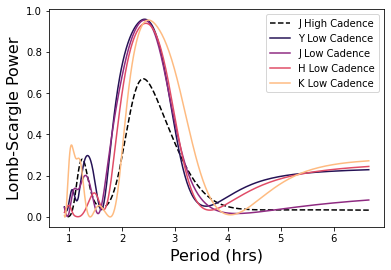

In [6]:
'Lomb-Scargle Periodograms'
from astropy.timeseries import LombScargle
frequency = np.linspace(0.15,1.1,500)
period = 1/frequency

'Flux Periodograms'
ls_J = LombScargle(hours_J,flux_J,error_J)
ls_Jhi = LombScargle(hours_J_high_cadence, flux_J_high_cadence,error_J_high_cadence)
ls_Jlow = LombScargle(hours_J_low_cadence, flux_J_low_cadence,error_J_low_cadence)
ls_H = LombScargle(hours_H, flux_H,error_H)
ls_K = LombScargle(hours_K, flux_K,error_K)
ls_Y = LombScargle(hours_Y, flux_Y,error_Y)
power_J = LombScargle(hours_J,flux_J,error_J).power(frequency)
power_Jhi = LombScargle(hours_J_high_cadence, flux_J_high_cadence,error_J_high_cadence).power(frequency)
power_Jlow = LombScargle(hours_J_low_cadence, flux_J_low_cadence,error_J_low_cadence).power(frequency)
power_H = LombScargle(hours_H, flux_H,error_H).power(frequency)
power_K = LombScargle(hours_K, flux_K,error_K).power(frequency)
power_Y = LombScargle(hours_Y, flux_Y,error_Y).power(frequency)

'Plot L-S Periodogram'
fig, arr = plt.subplots()
plt.plot(period,power_Jhi,label='J High Cadence',ls = '--',linewidth = 1.5,color = p.black())
plt.plot(period,power_Y,label='Y Low Cadence',color = color_Y)
plt.plot(period,power_Jlow,label='J Low Cadence',color = color_J)
plt.plot(period,power_H,label='H Low Cadence',color = color_H)
plt.plot(period,power_K,label='K Low Cadence',color = color_K)
plt.xlabel('Period (hrs)',fontsize = 16)
plt.ylabel('Lomb-Scargle Power',fontsize = 16)
plt.legend()

We use Dynamic Nested Sampling via Dynesty (Speagle, 2020) to infer waves and spotted models. Here we will demonstrate inferring a 3-wave model (bands) with the high cadence J-band data. Note that for bands, we multiply the normalized data by 100 (to convert to percentages) for ease of use. We convert back to fractions later for plotting.

34812it [03:57, 146.80it/s, batch: 4 | bound: 38 | nc: 31 | ncall: 1028547 | eff(%):  3.385 | loglstar: -3.775 <  4.458 <  2.024 | logz: -45.826 +/-  0.242 | stop:  0.840]                  


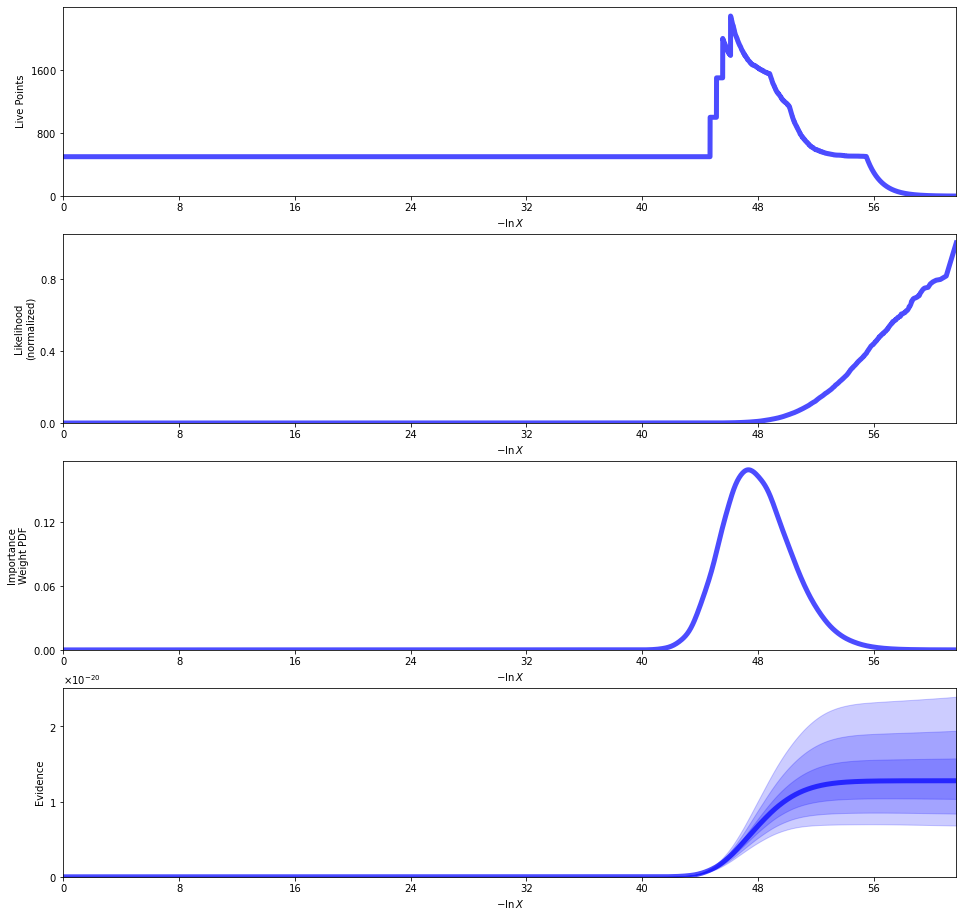

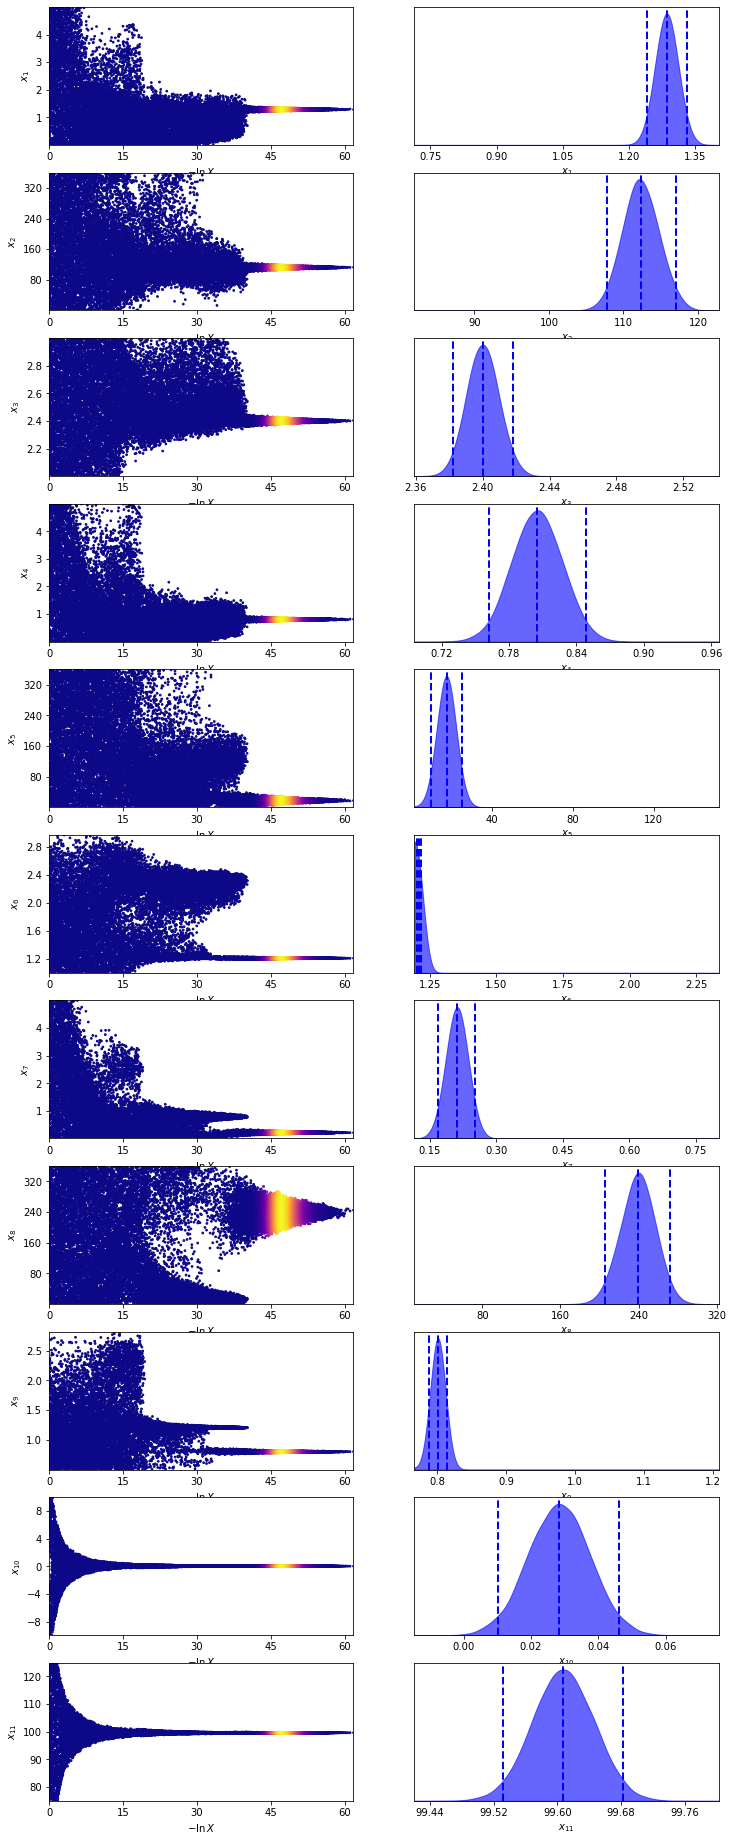

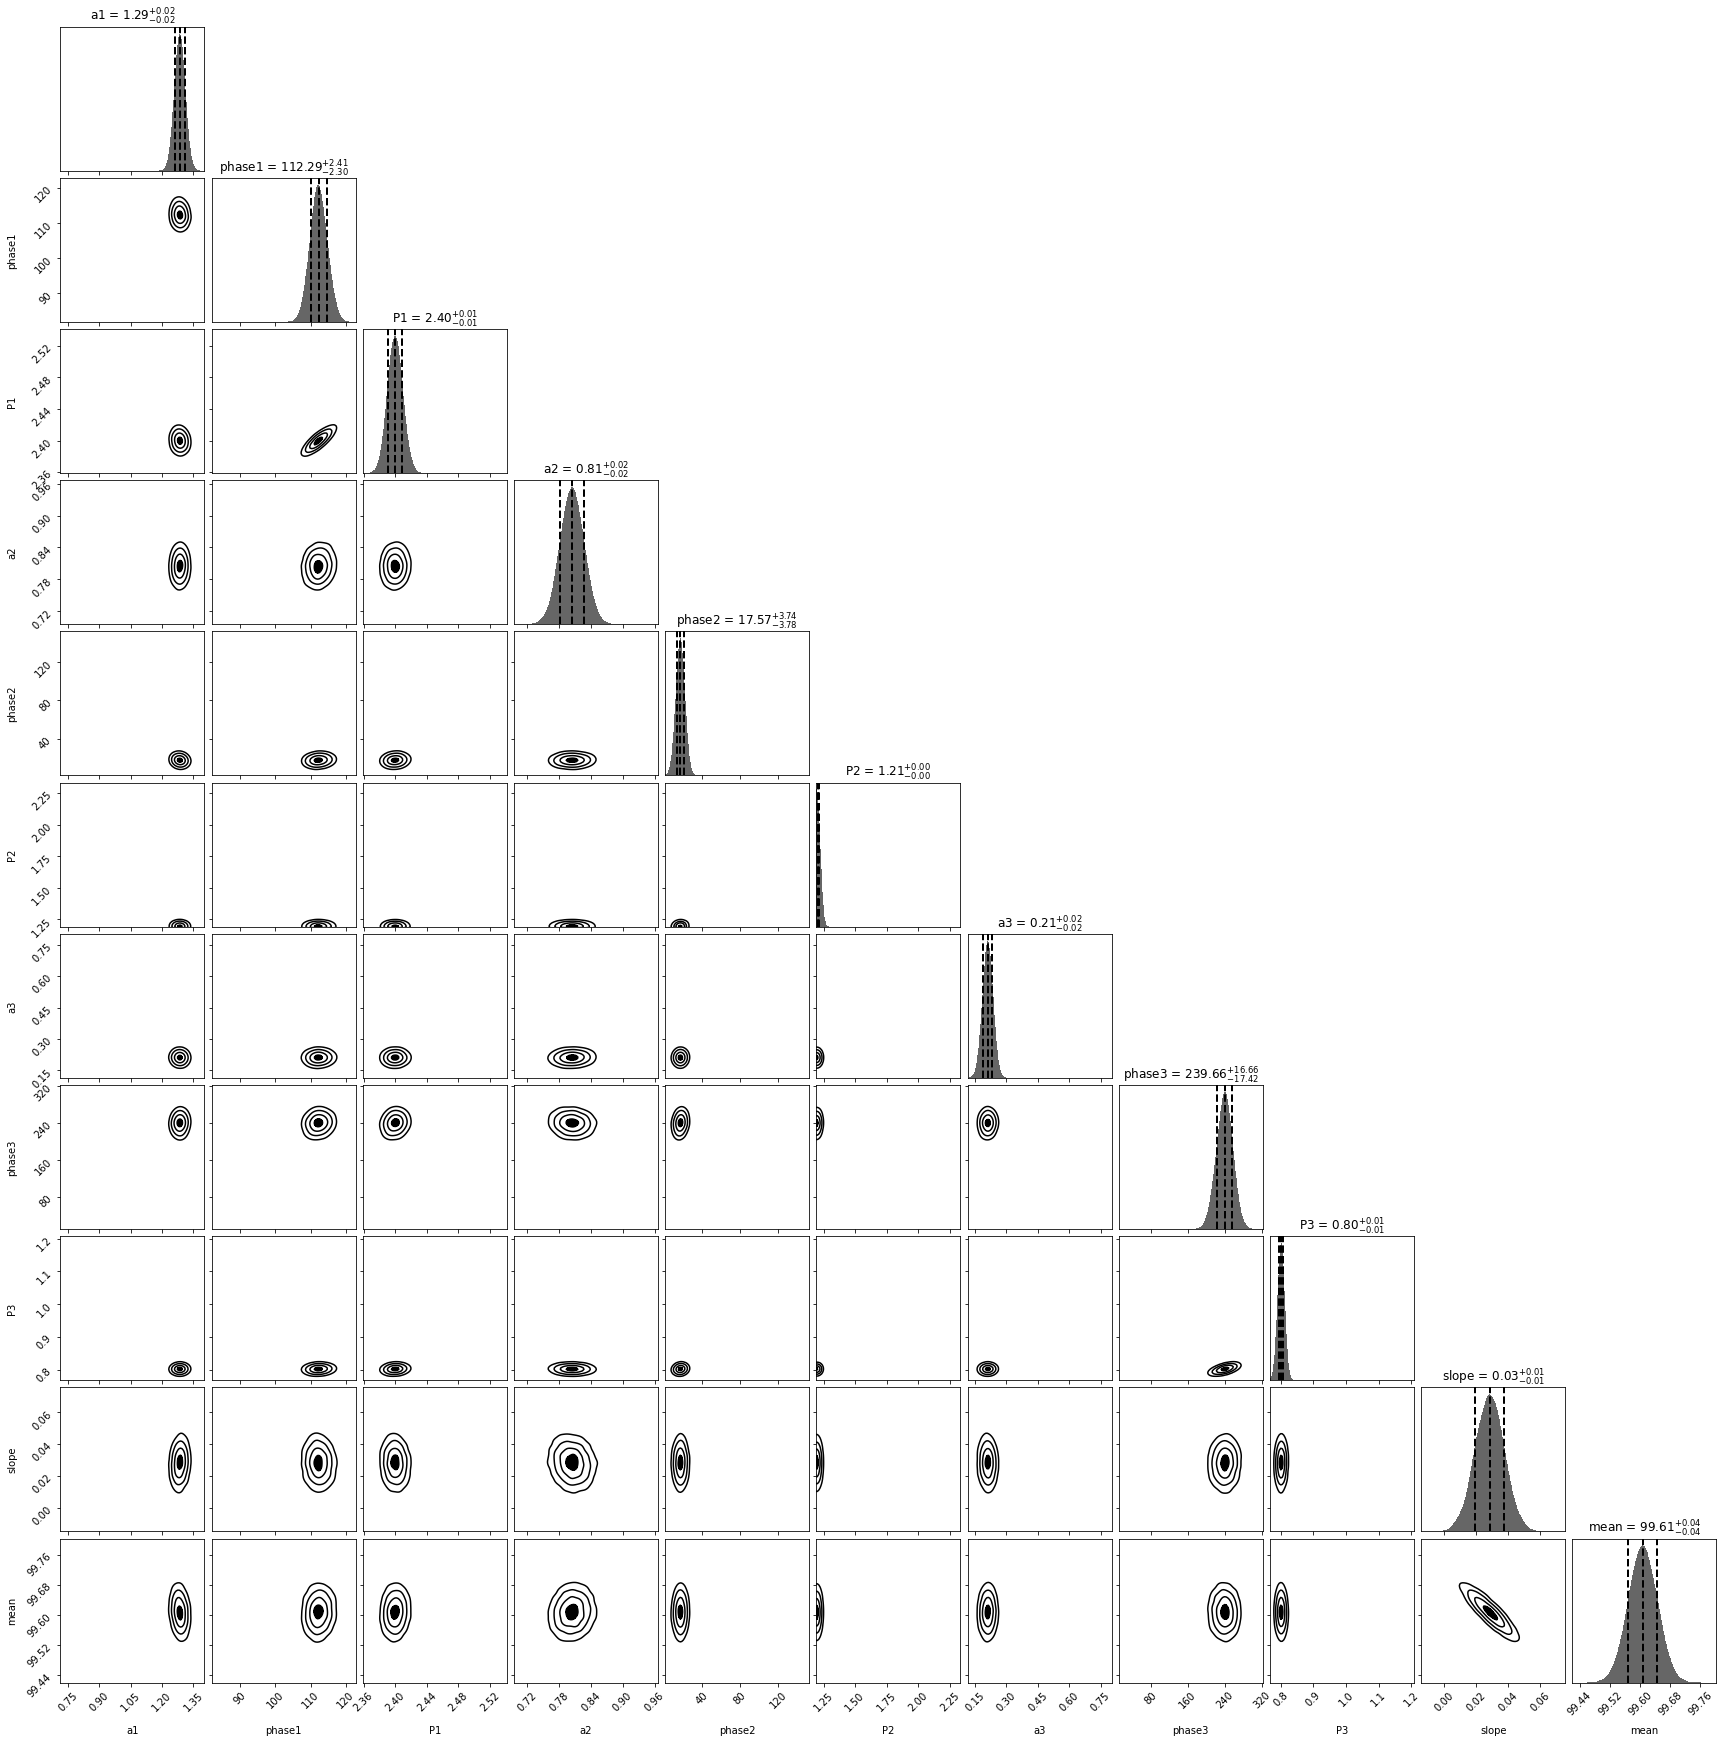

In [7]:
'Nested Sampling'
data_type = 'J_high' # Options: 'J_high', 'J_low', 'H','K','Y','low_all','J_2nights'
perform_nested_sampling = True
if perform_nested_sampling == True:
    time_samples = 2000
    num_bands = 3
    num_spots = 0
    free_bias = False #Needs to be turned to True for spot models/ False for Bands
    amp1_mode = True # True for bands, False for spots
    evolution_spot_number = False #[0,1] # Set to False if no spot evolution, otherwise set which spot to evolve
    evolution_rotation = False #[2,1] # Set to False if not spot evolution, otherwise set to which rotation evolution should end on
    if num_bands == 0:
        flux_factor = 1
    else:
        flux_factor = 100 #For the banded models, we use percent and then convert back
    if data_type == 'J_high':
        target_flux = flux_factor*flux_J_high_cadence
        target_time = hours_J_high_cadence
        target_snr = 1/(flux_factor*error_J_high_cadence)
    elif data_type == 'J_low':
        target_flux = flux_factor*flux_J_low_cadence
        target_time = hours_J_low_cadence
        target_snr = 1/(error_J_low_cadence*flux_factor)
    elif data_type == 'H':
        target_flux = flux_factor*flux_H
        target_time = hours_H
        target_snr = 1/(error_H*flux_factor)
    elif data_type == 'K':
        target_flux = flux_factor*flux_K
        target_time = hours_K
        target_snr = 1/(error_K*flux_factor)
    elif data_type == 'Y':
        target_flux = flux_factor*flux_Y
        target_time = hours_Y
        target_snr = 1/(error_Y*flux_factor)
    elif data_type == 'low_all':
        target_flux = flux_factor*flux_low_all
        target_time = hours_low_all
        target_snr = 1/(error_low_all*flux_factor)
    elif data_type == 'J_2nights':
        target_flux = flux_factor*flux_J
        target_time = hours_J
        target_snr = 1/(error_J*flux_factor)
    target_observation = Imber.Photometric_Observation(target_flux, target_time, target_snr)
    inference = Imber.NestedSampling(target, time_samples, photo_observation=target_observation,\
                                             free_radius=True, free_contrast=True, 
                                                 num_bands=num_bands,num_spots = num_spots,\
                                                     evolution_spot_number=evolution_spot_number,\
                                                         evolution_rotation=evolution_rotation,amp1_mode = amp1_mode, \
                                                             free_bias = free_bias)
    inference.run()


Based on the nested sampling results, we build analytical models.

In [24]:
'Model Parameters'
length_of_observation = hours_J_high_cadence[-1]
time_steps = 200 # This is for our model
n = 101 # Width of 1D flux array
eps = 0.5 # Linear limb darkening coefficent (based on Plummer & Wang, 2022's Luhman 16B value)
spectral_resolution = 100E3 #Because this is photometry, this value just needs to be set to an arbitrarily high value

'High Cadence, J-Band, 3-Waves'
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
model_time_hi = model_time
photo_slope,photo_mean = 0.03,99.61 #BIC 200.5
a1,phi1,P1 = 1.29,112.43,2.41
a2,phi2,P2 = 0.81,17.65,1.21
a3,phi3,P3 = 0.21,239.81,0.8
factor = 100
photo_slope,photo_mean,a1,a2,a3  =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor,a3/factor
tphoto = model_analytical.time_hours
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave3 = a3*np.sin(2*np.pi*tphoto/P3+(np.pi*phi3/180))
wave_curve = photo_mean+(photo_slope*tphoto)+wave1+wave2+wave3
ax11.plot(model_time,wave_curve,label = r'3-Waves',color = p.blue(shade = 60))
sample_points = np.interp(hours_J_high_cadence,model_time,wave_curve)
ax12.scatter(hours_J_high_cadence,flux_J_high_cadence-sample_points,color = p.blue(shade = 60),marker = '.')
chi2_Jhi_3bands = np.sum((flux_J_high_cadence-sample_points)**2/(error_J_high_cadence**2))
num_free_params = 11
num_data_points = len(flux_J_high_cadence)
BIC_Jhi_3bands = chi2_Jhi_3bands+(num_free_params*np.log(num_data_points))
save_that_wave = wave1,wave2,wave3,wave_curve,model_time,photo_mean,photo_slope

'Low Cadence, Y-Band, 2-Waves'
length_of_observation = hours_Y[-1]
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
model_time_low = model_time
photo_slope,photo_mean = -0.14,99.90
a1,phi1,P1 = 2.85,58.00,2.42
a2,phi2,P2 = 0.75,205.83,1.27
factor = 100
photo_slope,photo_mean,a1,a2 =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor
tphoto = model_analytical.time_hours
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave_curve = photo_mean+(photo_slope*tphoto)+wave1+wave2#+wave3
sample_points = np.interp(hours_Y,model_time,wave_curve)
residual = flux_Y-sample_points
chi2_Y_2bands = np.sum((flux_Y-sample_points)**2/(error_Y**2))
num_free_params = 8
num_data_points = len(flux_Y)
BIC_Y_2bands = chi2_Y_2bands+(num_free_params*np.log(num_data_points))
Y_curve = wave_curve
Y_curve1 = wave1
Y_curve2 = wave2
save_that_wave_Y = wave1,wave2,wave3,wave_curve,model_time,photo_mean,photo_slope,residual

'Low Cadence, J-Band, 2-Waves'
length_of_observation = hours_J_low_cadence[-1]
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
model_time_low = model_time
photo_slope,photo_mean = -0.16,98.81
a1,phi1,P1 = 2.94,57.95,2.43
a2,phi2,P2 = 0.67,190.91,1.26
factor = 100
photo_slope,photo_mean,a1,a2 =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor
tphoto = model_analytical.time_hours
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave_curve = photo_mean+(photo_slope*tphoto)+wave1+wave2
sample_points = np.interp(hours_J_low_cadence,model_time,wave_curve)
chi2_Jlow_2bands = np.sum((flux_J_low_cadence-sample_points)**2/(error_J_low_cadence**2))
num_free_params = 8
num_data_points = len(flux_J_low_cadence)
BIC_Jlow_2bands = chi2_Jlow_2bands+(num_free_params*np.log(num_data_points))
save_that_wave_Jlow = wave1,wave2,wave3,wave_curve,model_time,photo_mean,photo_slope
Jlow_curve1 = wave1
Jlow_curve2 = wave2
J_low_curve = wave_curve

'Low Cadence, H-Band, 2-Waves'
length_of_observation = hours_H[-1]
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
model_time_H = model_time
photo_slope,photo_mean = -0.21,99.53
a1,phi1,P1 = 2.86,56.93,2.44
a2,phi2,P2 = 0.68,182.53,1.27
factor = 100
photo_slope,photo_mean,a1,a2 =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor
tphoto = model_analytical.time_hours
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave_curve = photo_mean+(photo_slope*tphoto)+wave1+wave2
sample_points = np.interp(hours_H,model_time,wave_curve)
chi2_H_2bands = np.sum((flux_H-sample_points)**2/(error_H**2))
num_free_params = 8
num_data_points = len(flux_H)
BIC_H_2bands = chi2_H_2bands+(num_free_params*np.log(num_data_points))
save_that_wave_H = wave1,wave2,wave3,wave_curve,model_time,photo_mean,photo_slope
H_curve = wave_curve
H_curve1 = wave1
H_curve2 = wave2

'Low Cadence, K-Band, 2-Waves'
length_of_observation = hours_K[-1]
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
model_time_K = model_time
photo_slope,photo_mean = -0.16,99.93
a1,phi1,P1 = 1.88,52.01,2.43
a2,phi2,P2 = 0.36,152.07,1.27
factor = 100
photo_slope,photo_mean,a1,a2 =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor
tphoto = model_analytical.time_hours
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave_curve = photo_mean+(photo_slope*tphoto)+wave1+wave2
sample_points = np.interp(hours_K,model_time,wave_curve)
chi2_K_2bands = np.sum((flux_K-sample_points)**2/(error_K**2))
num_free_params = 8
num_data_points = len(flux_K)
BIC_K_2bands = chi2_K_2bands+(num_free_params*np.log(num_data_points))
save_that_wave_K = wave1,wave2,wave3,wave_curve,model_time,photo_mean,photo_slope
K_curve = wave_curve
K_curve1 = wave1
K_curve2 = wave2

'Low Cadence, Composite (Y+J+H+K) Data, 2-Waves'
length_of_observation = hours_low_all[-1]
model_analytical = Imber.Analytical_Model(target, length_of_observation, time_steps, n, eps, spectral_resolution)
tphoto = model_analytical.time_hours
model_time = tphoto
photo_slope,photo_mean = -0.17,99.43
a1,phi1,P1 = 2.62,51.95,2.41
a2,phi2,P2 = 0.57,175.41,1.26
factor = 100
photo_slope,photo_mean,a1,a2 =photo_slope/factor,photo_mean/factor, a1/factor,a2/factor
wave1 = a1*np.sin(2*np.pi*tphoto/P1+(np.pi*phi1/180))
wave2 = a2*np.sin(2*np.pi*tphoto/P2+(np.pi*phi2/180))
wave_curve_2band = photo_mean+(photo_slope*tphoto)+wave1+wave2
sample_points_2band = np.interp(hours_low_all,model_time,wave_curve_2band)
chi2_low_all_2bands = np.sum((flux_low_all-sample_points_2band)**2/(error_low_all**2))
num_free_params = 8
num_data_points = len(flux_low_all)
BIC_low_all_2bands= chi2_low_all_2bands+(num_free_params*np.log(num_data_points))
save_that_wave_low_all = wave1,wave2,wave3,wave_curve_2band,model_time,photo_mean,photo_slope
low_all_curve = wave_curve_2band


We also need to build uncertainty curves.

In [16]:
#J high cadence
'Jhigh Combined Wave'
n_waves = 3
inputs = np.zeros((n_waves,6))
length_of_observation = hours_J_high_cadence[-1]
inputs[0] = 1.29,0.02,2.41,0.01,112.43,np.mean([2.32,2.33])
inputs[1] = 0.81,0.02,1.21,0.005,17.65,np.mean([3.69,3.84])
inputs[2] = 0.21,0.02,0.80,0.01,239.81,np.mean([16.71,16.83])
bias_mean,bias_std,slope_mean,slope_std = 99.61,0.04,0.03,0.01
Jhigh_mean,Jhigh_std,time_x = Imber.wave_uncertainty(inputs,length_of_observation,time_steps,color_series = False,\
                                                     slope_mean= slope_mean,slope_std=slope_std,bias_mean=bias_mean,bias_std=bias_std)
Jhigh_std = Jhigh_std/100
'Jhigh 1st Component'
n_waves = 1
inputs = np.zeros((n_waves,6))
inputs[0] = 1.29,0.02,2.41,0.01,112.43,np.mean([2.32,2.33])
Jhigh_mean1,Jhigh_std1,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Jhigh_std1 = Jhigh_std1/100
'Jhigh 2nd Component'
inputs[0] =  0.81,0.02,1.21,0.005,17.65,np.mean([3.69,3.84])
Jhigh_mean2,Jhigh_std2,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Jhigh_std2 = Jhigh_std2/100
'Jhigh 3rd Component'
inputs[0] = 0.21,0.02,0.80,0.01,239.81,np.mean([16.71,16.83])
Jhigh_mean3,Jhigh_std3,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Jhigh_std3 = Jhigh_std3/100

#Y
'Y Combined Wave'
n_waves = 2
inputs = np.zeros((n_waves,6))
length_of_observation = hours_Y[-1]
inputs[0] = 2.85,0.11,2.42,0.03,58.00,np.mean([4.85,5.12])
inputs[1] = 0.75,0.11,1.27,0.02,205.83,np.mean([15.54,15.05])
bias_mean,bias_std,slope_mean,slope_std = 99.90,0.16,-0.14,0.06
Y_mean,Y_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False,\
                                                     slope_mean= slope_mean,slope_std=slope_std,bias_mean=bias_mean,bias_std=bias_std)
Y_std = Y_std/100
'Y 1st Component'
n_waves = 1
inputs = np.zeros((n_waves,6))
length_of_observation = hours_Y[-1]
inputs[0] = 2.85,0.11,2.42,0.03,58.00,np.mean([4.85,5.12])
Y_mean1,Y_std1,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Y_std1 = Y_std1/100
'Y 2nd Component'
inputs[0] = 0.75,0.11,1.27,0.02,205.83,np.mean([15.54,15.05])
Y_mean2,Y_std2,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Y_std2 = Y_std2/100

#J low cadence
'Jlow Combined Wave'
n_waves = 2
inputs = np.zeros((n_waves,6))
length_of_observation = hours_J_low_cadence[-1]
inputs[0] = 2.94,0.075,2.43,0.02,57.95,np.mean([3.14,3.23])
inputs[1] = 0.67,0.08,1.26,0.02,190.91,np.mean([13.78,12.19])
bias_mean,bias_std,slope_mean,slope_std = 98.81,0.125,-0.16,0.04 
Jlow_mean,Jlow_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False,\
                                                     slope_mean= slope_mean,slope_std=slope_std,bias_mean=bias_mean,bias_std=bias_std)
Jlow_std = Jlow_std/100
'Jlow 1st Component'
n_waves = 1
inputs = np.zeros((n_waves,6))
inputs[0] = 2.94,0.075,2.43,0.02,57.95,np.mean([3.14,3.23])
Jlow_mean1,Jlow_std1,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Jlow_std1 = Jlow_std1/100
'Jlow 2nd Component'
inputs[0] = 0.67,0.08,1.26,0.02,190.91,np.mean([13.78,12.19])
Jlow_mean2,Jlow_std2,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
Jlow_std2 = Jlow_std2/100

#H
'H Combined Wave'
n_waves = 2
inputs = np.zeros((n_waves,6))
length_of_observation = hours_H[-1]
inputs[0] = 2.86,0.09,2.44,0.03,56.93,np.mean([4.82,4.94])
inputs[1] = 0.68,0.0105,1.27,0.02,182.53,np.mean([15.86,16.58])
bias_mean,bias_std,slope_mean,slope_std = 99.53,0.15,-0.21,0.05
H_mean,H_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False,\
                                                     slope_mean= slope_mean,slope_std=slope_std,bias_mean=bias_mean,bias_std=bias_std)
H_std = H_std/100
'H 1st Component'
n_waves = 1
inputs = np.zeros((n_waves,6))
inputs[0] = 2.86,0.09,2.44,0.03,56.93,np.mean([4.82,4.94])
H_mean1,H_std1,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
H_std1 = H_std1/100
'H 2nd Component'
inputs[0] = 0.68,0.0105,1.27,0.02,182.53,np.mean([15.86,16.58])
H_mean2,H_std2,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
H_std2 = H_std2/100

#K
'K Combined Wave'
n_waves = 2
inputs = np.zeros((n_waves,6))
length_of_observation = hours_K[-1]
inputs[0] = 1.88,0.09,2.43,0.04,52.29,np.mean([7.19,7.06])
inputs[1] = 0.35,0.1,1.27,0.04,151.59,np.mean([34.29,32.74])
bias_mean,bias_std,slope_mean,slope_std = 99.93,0.0015,-0.16,0.05
K_mean,K_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False,\
                                                     slope_mean= slope_mean,slope_std=slope_std,bias_mean=bias_mean,bias_std=bias_std)
K_std = K_std/100
'K 1st Component'
n_waves = 1
inputs = np.zeros((n_waves,6))
inputs[0] = 1.88,0.09,2.43,0.04,52.29,np.mean([7.19,7.06])
K_mean1,K_std1,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
K_std1 = K_std1/100
'K 2nd Component'
inputs[0] = 0.35,0.1,1.27,0.04,151.59,np.mean([34.29,32.74])
K_mean2,K_std2,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = False)
K_std2 = K_std2/100

Now, we can plot the band-specific data, the models, and wave component breakdowns for the 1st night (Figure 4).

Text(0.5, 0, 'Rotations')

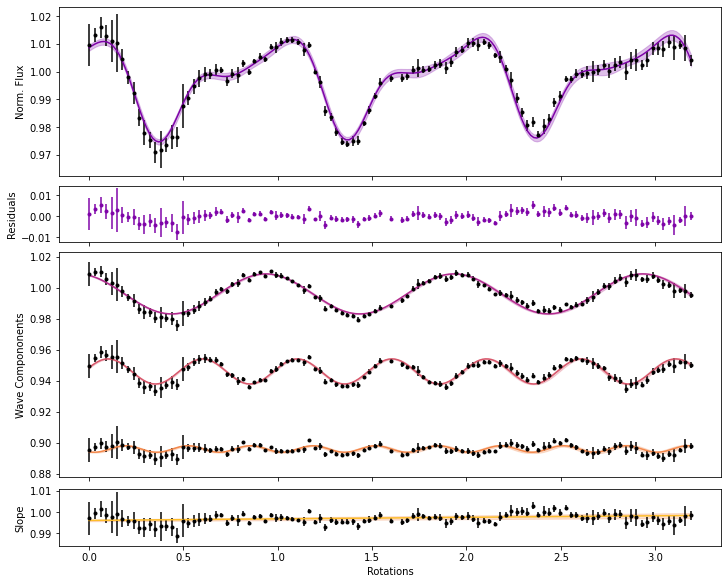

In [20]:
'3-Wave Components'
wave1,wave2,wave3,wave_curve,model_time,bias,slope = save_that_wave
model_time = model_time/period_hours
'Inputs'
ydata = flux_J_high_cadence
xdata = rotations_J_high_cadence
yerr = error_J_high_cadence
'Data controlled for other components'
curve_intper = np.interp(xdata,model_time,wave_curve)
w1_interp = np.interp(xdata,model_time,wave1)
w2_interp = np.interp(xdata,model_time,wave2)
w3_interp = np.interp(xdata,model_time,wave3)
w1_iso = ydata-(w2_interp+w3_interp+slope*period_hours*xdata)
w2_iso = ydata-(w1_interp+w3_interp+slope*period_hours*xdata)
w3_iso = ydata-(w1_interp+w2_interp+slope*period_hours*xdata)
slope_iso =  ydata-(w1_interp+w3_interp+w2_interp)
'Residual'
residual = ydata-curve_intper
'Plot'
figZ= plt.figure(constrained_layout=True,figsize=(10,8))
specZ = gridspec.GridSpec(ncols=1, nrows=4,height_ratios=[3,1,4,1],figure=figZ)
axZ1 = figZ.add_subplot(specZ[0])
axZ2 = figZ.add_subplot(specZ[1])
axZ3 = figZ.add_subplot(specZ[2])
axZ4 = figZ.add_subplot(specZ[3])
plt.setp(axZ1.get_xticklabels(), visible=False)
plt.setp(axZ2.get_xticklabels(), visible=False)
plt.setp(axZ3.get_xticklabels(), visible=False)
# plt.setp(aZ03.get_Zticklabels(), visible=False)
axZ1.errorbar(xdata,ydata,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ2.errorbar(xdata,residual,yerr = yerr,color = colour[color15],ls = 'none',marker = '.')
axZ3.errorbar(xdata,w1_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ3.errorbar(xdata,w2_iso-0.05,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ3.errorbar(xdata,w3_iso-0.1,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ4.errorbar(xdata,slope_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ1.plot(model_time,wave_curve,color = colour[color15])
axZ3.plot(model_time,wave1+bias,color = colour[color14])
axZ3.plot(model_time,wave2+bias-0.05, color = colour[color13])
axZ3.plot(model_time,wave3+bias-0.1,color = colour[color12])
axZ4.plot(model_time,(slope*model_time*period_hours)+bias,color = colour[color11])
# plt.Zlabel('Rotations',fontsize = 16)
# plt.ylabel('Normalized Flux (with offsets)',fontsize = 16)
# plt.ylim([0.8,1.0])

axZ1.fill_between(model_time,wave_curve-Jhigh_std,wave_curve+Jhigh_std,color =colour[color15],alpha = 0.25)
axZ3.fill_between(model_time,wave1+bias-Jhigh_std1,wave1+bias+Jhigh_std1,color =colour[color14],alpha = 0.25)
axZ3.fill_between(model_time,wave2+bias-0.05-Jhigh_std2,wave2+bias-0.05+Jhigh_std2,color =colour[color13],alpha = 0.25)
axZ3.fill_between(model_time,wave3+bias-0.1-Jhigh_std3,wave3+bias-0.1+Jhigh_std3,color =colour[color12],alpha = 0.25)
axZ4.fill_between(model_time,((slope-0.0001)*model_time*period_hours)+bias-0.0004,((slope+0.0001)*model_time*period_hours)+bias+0.0004,color =colour[color12],alpha = 0.25)


axZ1.set_ylabel('Norm. Flux')
axZ2.set_ylabel('Residuals')
axZ3.set_ylabel('Wave Compononents')
axZ4.set_ylabel('Slope')
axZ4.set_xlabel('Rotations')




And also plot the second night's observation, models, and wave components (Figure 5).

Text(0.5, 0, 'Rotations')

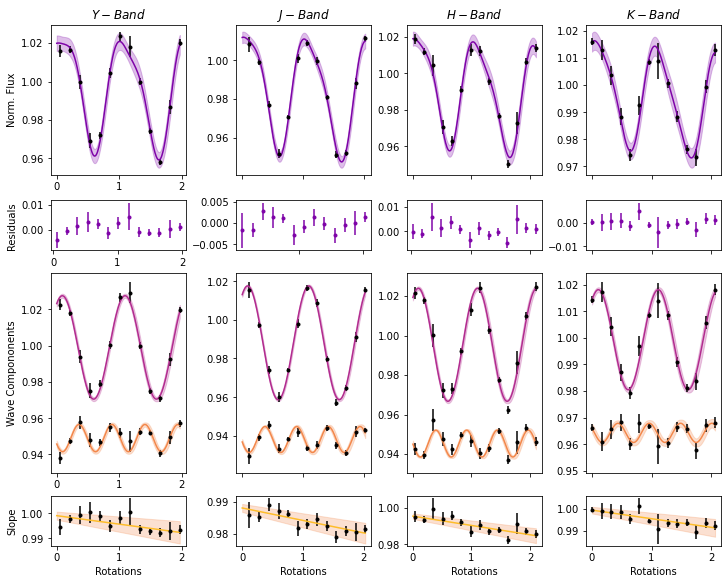

In [27]:
'3-Wave Components -- Low Cadence'
wave1,wave2,wave3,wave_curve,model_time,bias,slope,residual = save_that_wave_Y
# model_time = model_time_low
'Inputs'
ydata = flux_Y
xdata = hours_Y
yerr = error_Y
'Data controlled for other components'
curve_intper = np.interp(xdata,model_time,wave_curve)
w1_interp = np.interp(xdata,model_time,wave1)
w2_interp = np.interp(xdata,model_time,wave2)
w3_interp = 0#np.interp(xdata,model_time,wave3)
w1_iso = ydata-(w2_interp+slope*xdata)
w2_iso = ydata-(w1_interp+slope*xdata)
w3_iso = 0#ydata-(w1_interp+w2_interp+slope*period_hours*xdata)
slope_iso =  ydata-(w1_interp+w3_interp+w2_interp)
'Residual'
residual = ydata-curve_intper
'Plot'
xdata = rotations_Y
model_time = model_time/period_hours
figZ= plt.figure(constrained_layout=True,figsize = (10,8))
specZ = gridspec.GridSpec(ncols=4, nrows=4,height_ratios=[3,1,4,1],figure=figZ)
axZ01 = figZ.add_subplot(specZ[0,0])
axZ02 = figZ.add_subplot(specZ[1,0])
axZ03 = figZ.add_subplot(specZ[2,0])
axZ04 = figZ.add_subplot(specZ[3,0])
plt.setp(axZ1.get_xticklabels(), visible=False)
plt.setp(axZ2.get_xticklabels(), visible=False)
plt.setp(axZ3.get_xticklabels(), visible=False)
# plt.setp(aZ03.get_Zticklabels(), visible=False)
axZ01.errorbar(xdata,ydata,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ02.errorbar(xdata,residual,yerr = yerr,color = colour[color15],ls = 'none',marker = '.')
axZ03.errorbar(xdata,w1_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ03.errorbar(xdata,w2_iso-0.05,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
# axZ3.errorbar(xdata,w3_iso-0.2,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ04.errorbar(xdata,slope_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ01.plot(model_time,wave_curve,color = colour[color15])
axZ03.plot(model_time,wave1+bias,color = colour[color14])
axZ03.plot(model_time,wave2+bias-0.05, color = colour[color12])

axZ01.fill_between(model_time,wave_curve-Y_std,wave_curve+Y_std,color =colour[color15],alpha = 0.25)
axZ03.fill_between(model_time,wave1+bias-Y_std1,wave1+bias+Y_std1,color =colour[color14],alpha = 0.25)
axZ03.fill_between(model_time,wave2+bias-0.05-Y_std2,wave2+bias-0.05+Y_std2,color =colour[color12],alpha = 0.25)
axZ04.fill_between(model_time,((slope-0.0006)*model_time*period_hours)+bias-0.0016,((slope+0.0006)*model_time*period_hours)+bias+0.0016,color =colour[color12],alpha = 0.25)


axZ04.plot(model_time,(slope*model_time*period_hours)+bias,color = colour[color11])

axZ01.set_ylabel('Norm. Flux')
axZ02.set_ylabel('Residuals')
axZ03.set_ylabel('Wave Compononents')
axZ04.set_ylabel('Slope')

'3-Wave Components -- Low Cadence'
wave1,wave2,wave3,wave_curve,model_time,bias,slope = save_that_wave_Jlow
model_time = model_time/period_hours
'Inputs'
ydata = flux_J_low_cadence
xdata = rotations_J_low_cadence
yerr = error_J_low_cadence
'Data controlled for other components'
curve_intper = np.interp(xdata,model_time,wave_curve)
w1_interp = np.interp(xdata,model_time,wave1)
w2_interp = np.interp(xdata,model_time,wave2)
w3_interp = 0#np.interp(xdata,model_time,wave3)
w1_iso = ydata-(w2_interp+w3_interp+slope*period_hours*xdata)
w2_iso = ydata-(w1_interp+w3_interp+slope*period_hours*xdata)
w3_iso = 0#ydata-(w1_interp+w2_interp+slope*period_hours*xdata)
slope_iso =  ydata-(w1_interp+w3_interp+w2_interp)
'Residual'
residual = ydata-curve_intper
'Plot'
axZ1 = figZ.add_subplot(specZ[0,1])
axZ2 = figZ.add_subplot(specZ[1,1])
axZ3 = figZ.add_subplot(specZ[2,1])
axZ4 = figZ.add_subplot(specZ[3,1])
plt.setp(axZ1.get_xticklabels(), visible=False)
plt.setp(axZ2.get_xticklabels(), visible=False)
plt.setp(axZ3.get_xticklabels(), visible=False)
# plt.setp(aZ03.get_Zticklabels(), visible=False)
axZ1.errorbar(xdata,ydata,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ2.errorbar(xdata,residual,yerr = yerr,color = colour[color15],ls = 'none',marker = '.')
axZ3.errorbar(xdata,w1_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ3.errorbar(xdata,w2_iso-0.05,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
# axZ3.errorbar(xdata,w3_iso-0.2,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ4.errorbar(xdata,slope_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ1.plot(model_time,wave_curve,color = colour[color15])
axZ3.plot(model_time,wave1+bias,color = colour[color14])
axZ3.plot(model_time,wave2+bias-0.05, color = colour[color12])
# axZ3.plot(model_time,wave3+bias-0.2,color = colour[color12])
axZ4.plot(model_time,(slope*model_time*period_hours)+bias,color = colour[color11])
axZ1.fill_between(model_time,wave_curve-Jlow_std,wave_curve+Jlow_std,color =colour[color15],alpha = 0.25)
axZ3.fill_between(model_time,wave1+bias-Jlow_std1,wave1+bias+Jlow_std1,color =colour[color14],alpha = 0.25)
axZ3.fill_between(model_time,wave2+bias-0.05-Jlow_std2,wave2+bias-0.05+Jlow_std2,color =colour[color12],alpha = 0.25)
axZ4.fill_between(model_time,((slope-0.0004)*model_time*period_hours)+bias-0.00125,((slope+0.0004)*model_time*period_hours)+bias+0.00125,color =colour[color12],alpha = 0.25)

'Add H Data'
wave1,wave2,wave3,wave_curve,model_time,bias,slope = save_that_wave_H
model_time = model_time_H/period_hours
'Inputs'
ydata = flux_H
xdata = rotations_H
yerr = error_H
'Data controlled for other components'
curve_intper = np.interp(xdata,model_time,wave_curve)
w1_interp = np.interp(xdata,model_time,wave1)
w2_interp = np.interp(xdata,model_time,wave2)
w3_interp = 0#np.interp(xdata,model_time,wave3)
w1_iso = ydata-(w2_interp+w3_interp+slope*period_hours*xdata)
w2_iso = ydata-(w1_interp+w3_interp+slope*period_hours*xdata)
w3_iso = 0#ydata-(w1_interp+w2_interp+slope*period_hours*xdata)
slope_iso =  ydata-(w1_interp+w3_interp+w2_interp)
'Residual'
residual = ydata-curve_intper
axZ5 = figZ.add_subplot(specZ[0,2])
axZ6 = figZ.add_subplot(specZ[1,2])
axZ7 = figZ.add_subplot(specZ[2,2])
axZ8 = figZ.add_subplot(specZ[3,2])
plt.setp(axZ5.get_xticklabels(), visible=False)
plt.setp(axZ6.get_xticklabels(), visible=False)
plt.setp(axZ7.get_xticklabels(), visible=False)
# plt.setp(aZ03.get_Zticklabels(), visible=False)
axZ5.errorbar(xdata,ydata,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ6.errorbar(xdata,residual,yerr = yerr,color = colour[color15],ls = 'none',marker = '.')
axZ7.errorbar(xdata,w1_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ7.errorbar(xdata,w2_iso-0.05,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
# axZ7.errorbar(xdata,w3_iso-0.2,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ8.errorbar(xdata,slope_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ5.plot(model_time,wave_curve,color = colour[color15])
axZ7.plot(model_time,wave1+bias,color = colour[color14])
axZ7.plot(model_time,wave2+bias-0.05, color = colour[color12])
# axZ7.plot(model_time,wave3+bias-0.2,color = colour[color12])
axZ8.plot(model_time,(slope*model_time*period_hours)+bias,color = colour[color11])

axZ5.fill_between(model_time,wave_curve-H_std,wave_curve+H_std,color =colour[color15],alpha = 0.25)
axZ7.fill_between(model_time,wave1+bias-H_std1,wave1+bias+H_std1,color =colour[color14],alpha = 0.25)
axZ7.fill_between(model_time,wave2+bias-0.05-H_std2,wave2+bias-0.05+H_std2,color =colour[color12],alpha = 0.25)
axZ8.fill_between(model_time,((slope-0.0005)*model_time*period_hours)+bias-0.0015,((slope+0.0005)*model_time*period_hours)+bias+0.0015,color =colour[color12],alpha = 0.25)

'Add K Data'
wave1,wave2,wave3,wave_curve,model_time,bias,slope = save_that_wave_K
model_time = model_time_K/period_hours
'Inputs'
ydata = flux_K
xdata = rotations_K
yerr = error_K
'Data controlled for other components'
curve_intper = np.interp(xdata,model_time,wave_curve)
w1_interp = np.interp(xdata,model_time,wave1)
w2_interp = np.interp(xdata,model_time,wave2)
w3_interp = 0#np.interp(xdata,model_time,wave3)
w1_iso = ydata-(w2_interp+w3_interp+slope*period_hours*xdata)
w2_iso = ydata-(w1_interp+w3_interp+slope*period_hours*xdata)
w3_iso = 0#ydata-(w1_interp+w2_interp+slope*period_hours*xdata)
slope_iso =  ydata-(w1_interp+w3_interp+w2_interp)
'Residual'
residual = ydata-curve_intper
axZ9= figZ.add_subplot(specZ[0,3])
axZ10 = figZ.add_subplot(specZ[1,3])
axZ11 = figZ.add_subplot(specZ[2,3])
axZ12 = figZ.add_subplot(specZ[3,3])
plt.setp(axZ9.get_xticklabels(), visible=False)
plt.setp(axZ10.get_xticklabels(), visible=False)
plt.setp(axZ11.get_xticklabels(), visible=False)
# plt.setp(aZ03.get_Zticklabels(), visible=False)
axZ9.errorbar(xdata,ydata,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ10.errorbar(xdata,residual,yerr = yerr,color = colour[color15],ls = 'none',marker = '.')
axZ11.errorbar(xdata,w1_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ11.errorbar(xdata,w2_iso-0.035,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
# axZ11.errorbar(xdata,w3_iso-0.2,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ12.errorbar(xdata,slope_iso,yerr = yerr,color = p.black(),ls = 'none',marker = '.')
axZ9.plot(model_time,wave_curve,color = colour[color15])
axZ11.plot(model_time,wave1+bias,color = colour[color14])
axZ11.plot(model_time,wave2+bias-0.035, color = colour[color12])
# axZ11.plot(model_time,wave3+bias-0.2,color = colour[color12])
axZ12.plot(model_time,(slope*model_time*period_hours)+bias,color = colour[color11])

axZ9.fill_between(model_time,wave_curve-K_std,wave_curve+K_std,color =colour[color15],alpha = 0.25)
axZ11.fill_between(model_time,wave1+bias-K_std1,wave1+bias+K_std1,color =colour[color14],alpha = 0.25)
axZ11.fill_between(model_time,wave2+bias-0.035-K_std2,wave2+bias-0.035+K_std2,color =colour[color12],alpha = 0.25)
axZ12.fill_between(model_time,((slope-0.0005)*model_time*period_hours)+bias-0.0015,((slope+0.0005)*model_time*period_hours)+bias+0.0015,color =colour[color12],alpha = 0.25)

'Set Subtitiles'
axZ01.set_title(r'$Y-Band$')
axZ1.set_title(r'$J-Band$')
axZ5.set_title(r'$H-Band$')
axZ9.set_title(r'$K-Band$')

axZ04.set_xlabel('Rotations')
axZ4.set_xlabel('Rotations')
axZ8.set_xlabel('Rotations')
axZ12.set_xlabel('Rotations')

Finally, we perform the calculations necessary for our color times series and plot the results (Figure 6).

(-0.044, 0.026)

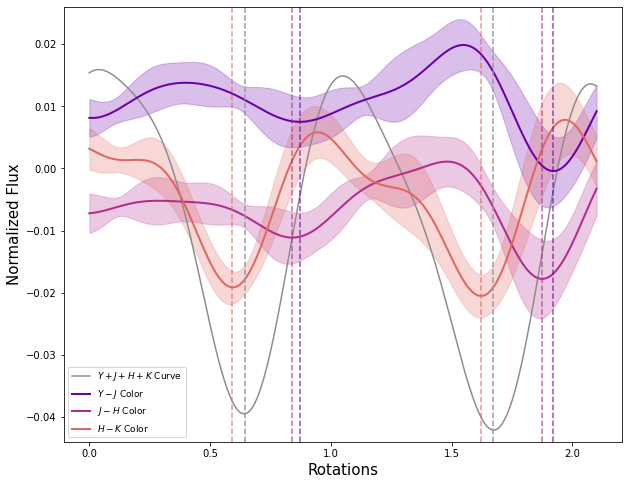

In [26]:
'Color Series Waves w/ Uncertainty'
n_waves = 4
inputs = np.zeros((n_waves,6))
length_of_observation = hours_H[-1]

'Y-J'
#Y
inputs[0] = 2.85,0.11,2.42,0.03,58.00,np.mean([4.85,5.12])
inputs[1] = 0.75,0.11,1.27,0.02,205.83,np.mean([15.54,15.05])

#J low
inputs[2] = 2.94,0.075,2.43,0.02,57.95,np.mean([3.14,3.23])
inputs[3] = 0.67,0.08,1.26,0.02,190.91,np.mean([13.78,12.19])

YJcolor_mean,YJcolor_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = True)
YJcolor_mean,YJcolor_std = YJcolor_mean/100,YJcolor_std/100

'J - H'
#J low
inputs[0] = 2.94,0.075,2.43,0.02,57.95,np.mean([3.14,3.23])
inputs[1] = 0.67,0.08,1.26,0.02,190.91,np.mean([13.78,12.19])

#H
inputs[2] = 2.86,0.09,2.44,0.03,56.93,np.mean([4.82,4.94])
inputs[3] = 0.68,0.0105,1.27,0.02,182.53,np.mean([15.86,16.58])

JHcolor_mean,JHcolor_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = True)
JHcolor_mean,JHcolor_std = JHcolor_mean/100,JHcolor_std/100

'H - K'
#H
inputs[0] = 2.86,0.09,2.44,0.03,56.93,np.mean([4.82,4.94])
inputs[1] = 0.68,0.0105,1.27,0.02,182.53,np.mean([15.86,16.58])

#K
inputs[2] = 1.88,0.09,2.43,0.04,52.29,np.mean([7.19,7.06])
inputs[3] = 0.35,0.1,1.27,0.04,151.59,np.mean([34.29,32.74])

HKcolor_mean,HKcolor_std,time_x = Imber.wave_uncertainty(inputs, length_of_observation, time_steps,color_series = True)
HKcolor_mean,HKcolor_std = HKcolor_mean/100,HKcolor_std/100

fig,ax = plt.subplots(figsize = (10,8))

'Plot Y+J+H+K curve'
shade = 50
plt.plot(time_x/period_hours,low_all_curve-1.0,color = p.gray(shade = shade),label = r'$Y+J+H+K$ Curve')


'Plot Color Time Series'
lw = 2.0
plt.plot(time_x/period_hours,Y_curve-J_low_curve,color = colour[20],label = r'$Y-J$ Color',lw = lw)
plt.fill_between(time_x/period_hours,Y_curve-J_low_curve-YJcolor_std,Y_curve-J_low_curve+YJcolor_std,color =colour[20],alpha = 0.25)

plt.plot(time_x/period_hours,J_low_curve-H_curve,color = colour[40],label = r'$J-H$ Color',lw = lw)
plt.fill_between(time_x/period_hours,J_low_curve-H_curve-JHcolor_std,J_low_curve-H_curve+JHcolor_std,color =colour[40],alpha = 0.25)

plt.plot(time_x/period_hours,H_curve-K_curve,color = colour[60],label = r'$H-K$ Color',lw = lw)
plt.fill_between(time_x/period_hours,H_curve-K_curve-HKcolor_std,H_curve-K_curve+HKcolor_std,color =colour[60],alpha = 0.25)


'Vertical Lines'
ymin,ymax = -0.044,0.026
alpha = 0.7
plt.vlines(0.64396,ymin = ymin,ymax = ymax,color = p.gray(shade = 45),ls='--')
plt.vlines(1.673,ymin = ymin,ymax = ymax,color = p.gray(shade = 45),ls='--')
plt.vlines(0.87125,ymin = ymin,ymax = ymax,color = colour[20],ls='--',alpha = alpha)
plt.vlines(1.92125,ymin = ymin,ymax = ymax,color = colour[20],ls='--',alpha = alpha)
plt.vlines(0.838330,ymin = ymin,ymax = ymax,color = colour[40],ls='--',alpha = alpha)
plt.vlines(1.87320,ymin = ymin,ymax = ymax,color = colour[40],ls='--',alpha = alpha)
plt.vlines(0.59118,ymin = ymin,ymax = ymax,color = colour[60],ls='--',alpha = alpha)
plt.vlines(1.62147,ymin = ymin,ymax = ymax,color = colour[60],ls='--',alpha = alpha)
plt.xlabel('Rotations',fontsize = 15)
plt.ylabel('Normalized Flux',fontsize = 15)
plt.legend(loc = 'lower left',fontsize = 9)
plt.ylim(ymin,ymax)